# BEE 4750 Homework 3: Dissolved Oxygen and Monte Carlo

**Name**: MacKenzie Fountain

**ID**:5362163

> **Due Date**
>
> Thursday, 10/03/23, 9:00pm

## Overview

### Instructions

-   Problem 1 asks you to implement a model for dissolved oxygen in a
    river with multiple waste releases and use this to develop a
    strategy to ensure regulatory compliance.
-   Problem 2 asks you to use Monte Carlo simulation to assess how well
    your strategy from Problem 1 performs under uncertainty.
-   Problem 3 (5750 only) asks you to identify where a third discharge
    should be placed to maintain regulatory compliance.

### Load Environment

The following code loads the environment and makes sure all needed
packages are installed. This should be at the start of most Julia
scripts.

In [ ]:
import Pkg
Pkg.activate(@__DIR__)
Pkg.instantiate()

In [2]:
using Random
using Plots
using LaTeXStrings
using Distributions
using CSV
using DataFrames

## Problems (Total: 50/60 Points)

### Problem 1 (30 points)

A river which flows at 6 km/d is receiving waste discharges from two
sources which are 15 km apart. The oxygen reaeration rate is 0.55
day<sup>-1</sup>, and the decay rates of CBOD and NBOD are are 0.35 and
0.25 day<sup>-1</sup>, respectively. The river’s saturated dissolved
oxygen concentration is 10m g/L.

If the characteristics of the river inflow and waste discharges are
given in <a href="#tbl-river" class="quarto-xref">Table 1</a>, write a
Julia model to compute the dissolved oxygen concentration from the first
wastewater discharge to an arbitrary distance `d` km downstream. Use
your model to compute the maximum dissolved oxygen concentration up to
50km downstream and how far downriver this minimum occurs.

| Parameter | River Inflow | Waste Stream 1 | Waste Stream 2 |
|:--:|---:|---:|---:|
| Inflow | 100,000 m<sup>3</sup>/d | 10,000 m<sup>3</sup>/d | 15,000 m<sup>3</sup>/d |
| DO Concentration | 7.5 mg/L | 5 mg/L | 5 mg/L |
| CBOD | 5 mg/L | 50 mg/L | 45 mg/L |
| NBOD | 5 mg/L | 35 mg/L | 35 mg/L |

Table 1: River inflow and waste stream characteristics for Problem 1.

**In this problem**:

-   Plot the dissolved oxygen concentration from the first waste stream
    to 50km downriver. What is the minimum value in mg/L?
-   What is the minimum level of treatment (% removal of organic waste)
    for waste stream 1 that will ensure that the dissolved oxygen
    concentration never drops below 4 mg/L, assuming that waste stream 2
    remains untreated? How about if only waste stream 2 is treated?
-   Suppose you are responsible for designing a waste treatment plan for
    discharges into the river, with a regulatory mandate to keep the
    dissolved oxygen concentration above 4 mg/L. Discuss whether you’d
    opt to treat waste stream 2 alone or both waste streams equally.
    What other information might you need to make a conclusion, if any?

In [201]:

#create function to establish Intial Conditions
function intial_condition(Cr,Qr,Cw,Qw)
    Co=((Cr*Qr)+(Cw*Qw))/(Qr+Qw)
    return(Co)
end

function do_simulate(x, C0, B0, N0, ka, kn, kc, Cs, U)
    B = B0 * exp(-kc * x / U)
    N = N0 * exp(-kn * x / U)
    α1 = exp(-ka * x / U)
    α2 = (kc/(ka-kc)) * (exp.(-kc * x / U) - exp(-ka * x / U))
    α3 = (kn/(ka-kn)) * (exp(-kn * x / U) - exp(-ka * x / U))
    C = Cs * (1 - α1) + (C0 * α1) - (B0 * α2) - (N0 * α3)
    return (C, B, N)
end  
#modified function from in-class lecture

do_simulate (generic function with 1 method)

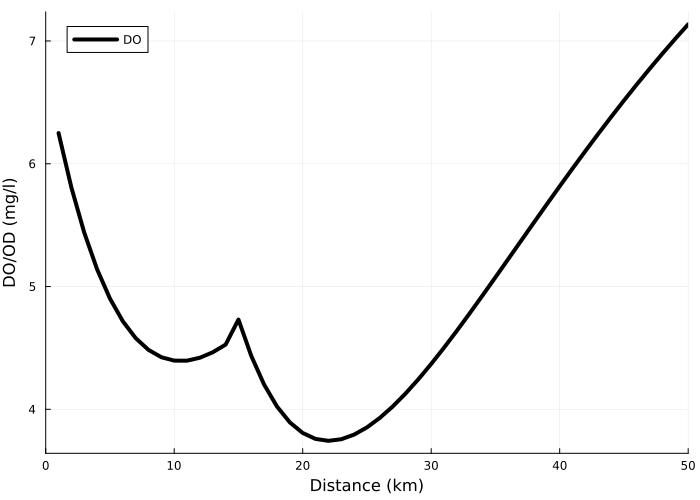

In [200]:

# set river properties
ka = 0.55
kc = 0.35
kn = 0.25

Cs = 10
U = 6


C0=intial_condition(7.5,10000,5,10000)
B0=intial_condition(5,100000,50,10000)
N0=intial_condition(5,100000,35,10000)
# evaluate model over all x's
# this uses broadcasting
(C,B,N) = (y -> do_simulate(y, C0, B0, N0, ka, kc, kn, Cs, U)).(15)
# unpack outputs into individual arrays for C, B, and N
# this uses comprehensions to pull out the relevant components 
#of the tuples that our function outputs
DO_Waste1 = (y -> do_simulate(y, C0, B0, N0, ka, kc, kn, Cs, U)).(0:15)
C1 = [d[1] for d in DO_Waste1]
B1 = [d[2] for d in DO_Waste1]
N1 = [d[3] for d in DO_Waste1]

C2=intial_condition(C,110000,5,15000)
B2=intial_condition(B,110000,45,15000)
N2=intial_condition(N,110000,35,15000)

x=0:35
do_out = (y -> do_simulate(y, C2, B2, N2, ka, kc, kn, Cs, U)).(x)
C = [d[1] for d in do_out]
B = [d[2] for d in do_out]
N = [d[3] for d in do_out]

# Adjust C_final indexing
C_final = zeros(50)
C_final[1:14] = C1[1:14]  # Now only take values from index 1 to 14 from C1
C_final[15:50] = C[1:36]  # Adjust accordingly based on the size of C

# plot outputs
p1 = plot(C_final, color=:black, linewidth=4, label="DO",  ylabel="DO/OD (mg/l)", xlabel="Distance (km)")
plot!(size=(700, 500))
xaxis!((0, 50))



In [179]:
minimum_value = C_final[1]  # Start with the first element of C
for i in 1:length(C)
    if C[i] < minimum_value
        minimum_value = C[i]
    end
end
println("The minimum is ", minimum_value)


The minimum is 3.74328762196204


In [182]:
# Function to simulate DO with treatment applied to Waste Streams
function simulate_with_treatment(treatment_factor_1, treatment_factor_2)
    # Adjust Waste Stream 1 with treatment
    B0_1 = intial_condition(5, 100000, 50 * (1 - treatment_factor_1), 10000)
    N0_1 = intial_condition(5, 100000, 35 * (1 - treatment_factor_1), 10000)
    
    # Adjust Waste Stream 2 with treatment
    B0_2 = intial_condition(7.5, 110000, 45 * (1 - treatment_factor_2), 15000)  # Use correct inflow values
    N0_2 = intial_condition(7.5, 110000, 35 * (1 - treatment_factor_2), 15000)

    # Simulate from Waste Stream 1 to Waste Stream 2 (0 to 15 km)
    DO_Waste1 = (y -> do_simulate(y, C0, B0_1, N0_1, ka, kc, kn, Cs, U)).(0:15)
    C1 = [d[1] for d in DO_Waste1]
    
    # Simulate from Waste Stream 2 to downstream (15 to 50 km)
    do_out = (y -> do_simulate(y, C1[end], B0_2, N0_2, ka, kc, kn, Cs, U)).(16:50)
    C2 = [d[1] for d in do_out]

    # Combine results into C_final
    C_final = vcat(C1, C2)  # Concatenate the two parts (first 15 km, then 16-50 km)

    return C_final
end


Minimum treatment for Waste Stream 2 is 45.0%


In [203]:

# Check treatment levels for Waste Stream 1 (while Waste Stream 2 remains untreated)
for treatment_level_1 in 0.0:0.01:1.0  # From 0% to 100% treatment (increments of 1%)
    C_final = simulate_with_treatment(treatment_level_1, 0.0)  # Waste Stream 2 untreated
    min_DO = minimum(C_final)
    if min_DO >= 4
        println("Minimum treatment for Waste Stream 1 is $(treatment_level_1 * 100)%")
        break
    end
end


After Waste Stream 1, the DO concentration does not go below 4.

In [204]:

# Check treatment levels for Waste Stream 2 (while Waste Stream 1 remains untreated)
for treatment_level_2 in 0.0:0.01:1.0  
    C_final = simulate_with_treatment(0.0, treatment_level_2)  # Waste Stream 1 untreated
    min_DO = minimum(C_final)
    if min_DO >= 4
        println("Minimum treatment for Waste Stream 2 is $(treatment_level_2 * 100)%")
        break
    end
end


Minimum treatment for Waste Stream 2 is 46.0%


I would treat waste stream 2, because thus would invole less resources and time used during treatment. Since, waste stream 1 alone does not allow the DO concentration to reach below four, soleyly treating waste stream two would be the most effeicent options for the time spent treating the waste and the resources used. Other information I would need to truly make an informed decidion is the overall need for the waster in the river, whether it goes to a town water supply or fully function ecosystem. I would need to know the chemicals or fungui in the waste that could affect the animals or humans that may dirnk the water.

### Problem 2 (20 points)

The simplest climate model involves capturing changes to the Earth’s
energy budget (it is commonly called the *energy balance model*, or
EBM). These changes are also called *radiative forcings* (RF), and can
result from several causes, including greenhouse gas emissions, volcanic
eruptions, and changes to the solar cycle. The EBM treats the Earth as a
0-dimensional sphere covered with water, which absorbs heat in response
to radiative forcings. Chanwith global temperature changes resulting
from imbalances in the average (over the entire surface area) heat flux.

The EBM equations are:

$$
\begin{align*}
\overbrace{\frac{dH}{dt}}^{\text{change in heat}} &= \overbrace{F}^{\substack{\text{radiative} \\ \text{forcing}}} - \overbrace{\lambda T}^{\substack{\text{change in} \\ \text{temperature}}} \\
\underbrace{C}_{\substack{\text{ocean heat} \\ \text{capacity}}} \frac{dT}{dt} &= F - \lambda T \\
c\underbrace{d}_{\substack{\text{ocean} \\ \text{mixing depth}}} \frac{dT}{dt} &= F - \lambda T,
\end{align*}
$$

where $c = 4.184\times 10^6 \mathrm{J/K/m}^2$ is the specific heat of
water per area, $d$ is the depth of the ocean mixed layer (we’ll assume
$d = 86 \mathrm{m}$), and $\lambda$ is the **climate feedback factor**
and controls how much the Earth warms in response to increased radiative
forcing (assume
$\lambda = 2.1^\circ \mathrm{C}/(\mathrm{W}/\mathrm{m}^2$)). The total
radiative forcing $F = F_\text{non-aerosol} + \alpha F_\text{aerosol}$,
where $\alpha$ is an uncertain scaling factor reflecting aerosol-cloud
feedbacks (we’ll assume $\alpha = 0.8$).

The code below loads historical and projected radiative forcings (under
the SSP5-8.5 future emissions scenario, which is the most extreme of the
scenarios used to project climate change impacts) from
`data/ERF_ssp585_1750-2500.csv` into a `DataFrame` object and calculates
the non-aerosol and aerosol components of those forcings.

> **Tip**
>
> Look closely at and experiment with the code below: `DataFrames` are a
> common Julia datatype for tabular data, and you may work more with
> them later in the semester or beyond! They are broadly similar to
> `DataFrames` from `pandas` in Python.

In [197]:
# Dataset from https://zenodo.org/record/3973015
# The CSV is read into a DataFrame object, and we specify that it is comma delimited
forcings_all = CSV.read("data/ERF_ssp585_1750-2500.csv", DataFrame, delim=",")

# Separate out the individual components
# Get total aerosol forcings
forcing_aerosol_rad = forcings_all[!,"aerosol-radiation_interactions"]
forcing_aerosol_cloud = forcings_all[!,"aerosol-cloud_interactions"]
forcing_aerosol = forcing_aerosol_rad + forcing_aerosol_cloud
# Calculate non-aerosol forcings from the total.
forcing_total = forcings_all[!,"total"]
forcing_non_aerosol = forcing_total - forcing_aerosol;

We can plot the aerosol and non-aerosol forcings below.

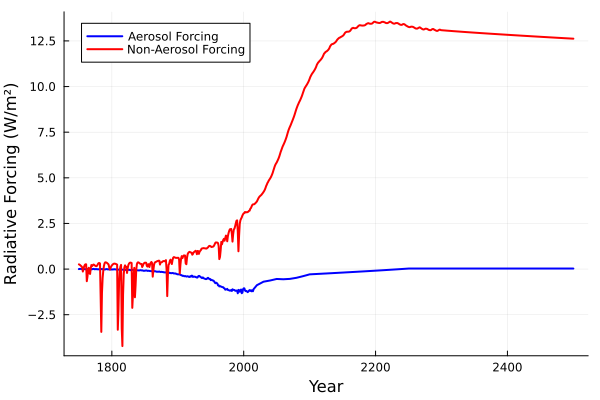

In [184]:
t = Int64.(forcings_all[!,"year"]) # Ensure that years are interpreted as integers
p_forcing = plot(; xlabel="Year", ylabel="Radiative Forcing (W/m²)")
plot!(p_forcing, t, forcing_aerosol, label="Aerosol Forcing", color=:blue, linewidth=2)
plot!(p_forcing, t, forcing_non_aerosol, label="Non-Aerosol Forcing", color=:red, linewidth=2)

**In this problem**:

-   Discretize the EBM to produce a simulation model of global mean
    temperatures $T$ over time as a result of total radiative forcings
    $F$.

-   Simulate global mean temperature anomalies (in $^\circ C$ relative
    to 1750) from your model using the historical and SSP5-8.5 radiative
    forcing data. Use an annual time step for the simulation (in
    seconds: $\Delta t = 31,558,152 \mathrm{s}$). You can assume
    $T(0) = 0^\circ C$. Plot the resulting temperature simulation.

-   The climate feedback factor $\lambda$ is one of the key
    uncertainties in projecting future temperatures, even assuming a
    particular scenario of future radiative forcing. Suppose we use the
    following distribution for $\lambda$,
    $$\lambda \sim \text{LogNormal}(\log(2.1), \log(2)/4).$$

    Use Monte Carlo simulation to estimate the expected temperature in
    2100 assuming SSP5-RCP 8.5 radiative forcings (with 95% confidence
    intervals). How does this estimate compare to the value you got from
    your simulation using the expected value of
    $\lambda=2.1^\circ \mathrm{C}/(\mathrm{W}/\mathrm{m}^2)$? How did
    you decide your sample set was sufficient?

In [185]:
# Define the discretized EBM function
function EBM(Hn, delta_t, Fn, lambda, Tn, c, d)
    # Equation for temperature (using mixing depth and heat capacity)
    T_next = Tn + (delta_t / (c * d)) * (Fn - lambda * Tn)
    return T_next
end


EBM (generic function with 1 method)

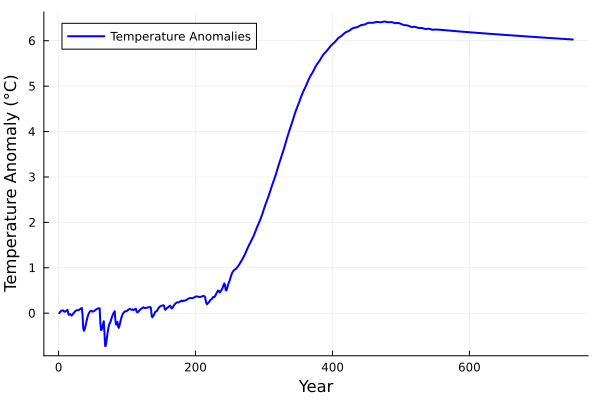

In [186]:

# Initialize constants
c = 4.184 * 10^6 
d = 86 
lambda = 2.1  
delta_t = 31558152 
a = 0.8  

# Initialize radiative forcing data
F = forcing_non_aerosol .+ (a * forcing_aerosol) 
# Number of years 
N = length(F)
# Initialize temperature array and heat
T = zeros(N) 
H = zeros(N)

# Simulation loop
for n in 1:N-1
    # Update temperature using the discretized EBM equation
    T[n+1] = EBM(H[n], delta_t, F[n], lambda, T[n], c, d)
end

# Plot 
using Plots
plot(1:N, T, xlabel="Year", ylabel="Temperature Anomaly (°C)", label="Temperature Anomalies", lw=2, color=:blue)


In [212]:
using Distributions #to ultilize lognormal function
# Create the LogNormal distribution and generate samples
lambda_dist = LogNormal((log(2.1)), (log(2) / 4));
samples = rand(lambda_dist, 5000);
#bell curve is present with 5000 samples in distribution
#referance from Lab 2

10000-element Vector{Float64}:
 2.3759310879596773
 1.4962597989316913
 1.9199449489863587
 2.332481448790192
 1.7663710728188593
 2.6594550237874603
 1.9580007855206518
 2.751922993731369
 1.8308977887237308
 2.4581026269417685
 ⋮
 1.9606538473424824
 2.468556633384193
 1.7954372821451852
 2.345224658469511
 2.3405341336970125
 1.9967934595965215
 1.970900724443325
 2.6459583898971886
 1.791353846531169

In [213]:
using Distributions
using Statistics
using Plots

# Number of years (length of forcing data)
years_to_2100 = length(F)

# Function to simulate temperature anomalies with sampled lambda
function temperature_simulation(n_trials)
    T_samples = zeros(n_trials)  # Store temperature in 2100 for each trial
    for i = 1:n_trials
        lambda = rand(lambda_dist)  # Sample a new lambda value for each trial
        T = zeros(years_to_2100)    # Initialize temperature array

        # Simulate the temperature over time
        for n = 1:years_to_2100-1
            T[n+1] = T[n] + (delta_t / (c * d)) * (F[n] - lambda * T[n])
        end
        T_samples[i] = T[end]  # Store temperature anomaly in 2100
    end
    return T_samples
end

# Set parameters
nsamp = 5000 
samples = temperature_simulation(nsamp)  # Run the simulations
#Choosing 5000 samples becuase when testing convergence of 5000, convergence was successful

# Initialize storage for running average and standard error
avg_temp = zeros(nsamp)  # average temperature anomaly
std_temp = zeros(nsamp)  # standard error of the estimate

# Initialize the first sample 
avg_temp[1] = samples[1]
std_temp[1] = 0  # No standard error with only one sample

# Compute running averages and standard errors
for i = 2:nsamp
    avg_temp[i] = (avg_temp[i-1] * (i-1) + samples[i]) / i  
    std_temp[i] = std(samples[1:i]) / sqrt(i) 
end


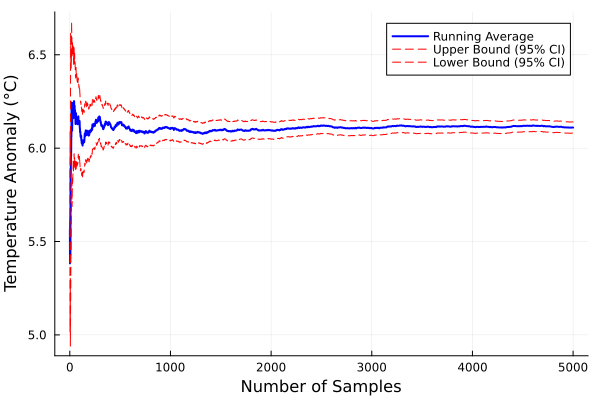

In [214]:

# Plot the running average temperature anomaly and standard error
plot(1:nsamp, avg_temp, xlabel="Number of Samples", ylabel="Temperature Anomaly (°C)", label="Running Average", lw=2, color=:blue)
plot!(1:nsamp, avg_temp .+ 2 .* std_temp, label="Upper Bound (95% CI)", lw=1, linestyle=:dash, color=:red)
plot!(1:nsamp, avg_temp .- 2 .* std_temp, label="Lower Bound (95% CI)", lw=1, linestyle=:dash, color=:red)
#chatgpt was used to set up plotting parameters

In [215]:

# final result
final_avg = avg_temp[end]
final_std = std_temp[end]
println("Expected temperature anomaly in 2100: $final_avg °C")
println("95% confidence interval: [", final_avg - 2 * final_std, ", ", final_avg + 2 * final_std, "] °C")
#chatgpt was used to adjust syntax and debug

Expected temperature anomaly in 2100: 6.1102959409486 °C
95% confidence interval: [6.080335344096705, 6.140256537800495] °C


The estimate from the Monte Carlo estimate is farly off from the expected value of 2.1°C at 6.1°C. I adjusted the sample size in the random distribution and the sample size from the monte carlo experiement and the expected temperture stayed the same. The experiment clearly converges with 5000 samples, so adding more will not change the outcome. The distribution of the sample showed a bell curves when plotted as well, which indicated that distribution was fair. Based on the confidence interval, the level of uncertainy is sufficent as well.

## References

ChatGPT was used for debugging and setting up plots as noted in code comments